# Description of the final project

## Introduction

This project is devoted to the question-answering task. You are going to work with the **BoolQ** dataset from SuperGLUE .

BoolQ is a question answering dataset for yes/no.

Each example is a triplet of (question, passage, answer), with the title of the page as optional additional context. The dataset release consists of three `.jsonl` files (`train, val, test`), where each line is a JSON dictionary with the following format:

    Example:
    
    {
      "question": "is france the same timezone as the uk",
      "passage": "At the Liberation of France in the summer of 1944, Metropolitan France kept GMT+2 as it was the time then used by the Allies (British Double Summer Time). In the winter of 1944--1945, Metropolitan France switched to GMT+1, same as in the United Kingdom, and switched again to GMT+2 in April 1945 like its British ally. In September 1945, Metropolitan France returned to GMT+1 (pre-war summer time), which the British had already done in July 1945. Metropolitan France was officially scheduled to return to GMT+0 on November 18, 1945 (the British returned to GMT+0 in on October 7, 1945), but the French government canceled the decision on November 5, 1945, and GMT+1 has since then remained the official time of Metropolitan France."
      "label": false,
      "idx": 123,
    }

For this project you will need only `train` and `val` parts.

Dataset is available here: https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip

Detailed task description is available here: https://arxiv.org/abs/1905.10044

## Bonus for those, who want to work with Russian

For those who want to work with Russian data there is an option to use **DaNetQA** dataset (instead of BoolQ) from Russsian SuperGLUE. The dataset is organised similarly to BoolQ.

You may download data from here: https://russiansuperglue.com/tasks/download/DaNetQA

Detailed task description is available here: https://arxiv.org/abs/2010.02605


**Note:** note that you should take only one dataset (either BoolQ or DanetQA). There are no bonus points for solving both tasks.


## Detailed Task Description

In the task you should perform all the model training on `train.jsonl` data and evaluate your models on `val.jsonl`. Note that you do not need `test.jsonl`.

Use **accuracy metric** for scoring.

The solution of either BoolQ or DaNetQA should include:


### [10%] 1. Data analysis


* 1.1  (10%) Download the data and calculate basic statistics (example number, class distribution, mean sentence length, number of unique words, etc.) and make visualizations, if necessary.


### [40%] 2. Pretrained embeddings as features for classifier
* 2.1 (5%) Take pre-trained word2vec or fastText embeddings and vectorize your data using them.

**Note:** you may use any pre-trained embeddings available on the Internet. For example, for English you may take GoogleNews vectors, which are available here: https://www.kaggle.com/leadbest/googlenewsvectorsnegative300 . For the Russian language you may choose one of the models from RusVectores (https://rusvectores.org/ru/models/).

* 2.2  (15%) Use pretrained embeddings as features to a classifier. Train SVM, Linear Regression or any other classification model. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).

* 2.3 (5%) Instead of word2vec or fastText embeddings get BERT embeddings from the train dataset and vectorize your data.

**Note:** you may use any of the BERT-like models from hugging face (https://huggingface.co/) library. For example, you may use `bert-base-multilingual-cased` (https://huggingface.co/bert-base-multilingual-cased).

* 2.4  (15%) Similarly to 2.1, train SVM, Linear Regression or any other classification model using BERT embeddings as features for a classifier. Describe and analyze your results (use accuracy metric and data from `val.jsonl` for evaluation of your results).


### [40%] 3. Fine-tune BERT

* 3.1 (10%) Split the data from `train.jsonl` into train and dev (dev_size = 10%) . Tokenize and format the data (do not forget about the [SEP] token).

* 3.2   (10%) Initialize the model, optimizer and learning rate scheduler. Explain your choice of the parameters.

* 3.3   (10%) Write a training loop and fine-tune BERT. Do to forget about evaluation on dev set created in 3.1.

**Note:** you may use one of the tutorials for fine-tuning BERT, but you have to provide a link to it. For example, you may use this one: https://mccormickml.com/2019/07/22/BERT-fine-tuning/

* 3.4   (10%)  Make predictions for the test data (from `val.jsonl`),  and analyze the results (use accuracy metric for scoring).



### [10%] 4. Summary & results analysis


* 4.1    (5%) Compare the results of all the tested models and try to interpret them.

* 4.2    (5%) Propose, how you may improve the model score (write at least three ideas).


### General Requirements

* You should provide a solution in the form of the Jupyter Notebook with code cells and markdown cells (with text)
* Make sure that the instructor can run all the cells to reproduce your results
* Clearly answer each question, perform the required actions from the task. Explain your decisions if you choose to use some techniques
* Provide links to the tutorials you use for reference.


---
---

# 1. Data loading and analysis

In [3]:
!wget https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip
!unzip BoolQ.zip

--2024-03-06 20:07:51--  https://dl.fbaipublicfiles.com/glue/superglue/data/v2/BoolQ.zip
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.227.219.70, 13.227.219.10, 13.227.219.59, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.227.219.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4118001 (3.9M) [application/zip]
Saving to: ‘BoolQ.zip’

BoolQ.zip           100%[===================>]   3.93M  --.-KB/s    in 0.05s   

2024-03-06 20:07:51 (74.3 MB/s) - ‘BoolQ.zip’ saved [4118001/4118001]

Archive:  BoolQ.zip
   creating: BoolQ/
  inflating: BoolQ/train.jsonl       
  inflating: BoolQ/test.jsonl        
  inflating: BoolQ/val.jsonl         


In [4]:
import pandas as pd
import numpy as np
import random

import nltk
nltk.download('punkt')
from nltk.tokenize import RegexpTokenizer, sent_tokenize

import gdown
from gensim import models

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler, random_split
from transformers import BertTokenizer, BertForSequenceClassification, AutoTokenizer, AutoModelForSequenceClassification, get_linear_schedule_with_warmup

import seaborn as sns
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [5]:
# Setting random seed for reproducibility

#---------------------#
seed_val = 225
#---------------------#

In [6]:
train_df = pd.read_json('BoolQ/train.jsonl', lines=True)
val_df = pd.read_json('BoolQ/val.jsonl', lines=True)

train_df.shape, val_df.shape

((9427, 4), (3270, 4))

In [7]:
display(train_df.head())
print()
display(val_df.head())

,question,passage,idx,label
0,do iran and afghanistan speak the same language,"Persian language -- Persian (/ˈpɜːrʒən, -ʃən/)...",0,True
1,do good samaritan laws protect those who help ...,Good Samaritan law -- Good Samaritan laws offe...,1,True
2,is windows movie maker part of windows essentials,Windows Movie Maker -- Windows Movie Maker (fo...,2,True
3,is confectionary sugar the same as powdered sugar,"Powdered sugar -- Powdered sugar, also called ...",3,True
4,is elder scrolls online the same as skyrim,The Elder Scrolls Online -- As with other game...,4,False


,question,passage,idx,label
0,does ethanol take more energy make that produces,Ethanol fuel -- All biomass goes through at le...,0,False
1,is house tax and property tax are same,Property tax -- Property tax or 'house tax' is...,1,True
2,is pain experienced in a missing body part or ...,Phantom pain -- Phantom pain sensations are de...,2,True
3,is harry potter and the escape from gringotts ...,Harry Potter and the Escape from Gringotts -- ...,3,True
4,is there a difference between hydroxyzine hcl ...,Hydroxyzine -- Hydroxyzine preparations requir...,4,True


In [6]:
pattern = r'\w+'
tokenizer = RegexpTokenizer(pattern)

def preprocessing(df):
    df['example'] = df.question + " " + df.passage
    df['question_sent_tokenized'] = df.question.apply(sent_tokenize).apply(lambda x: [tokenizer.tokenize(sentence.lower()) for sentence in x])
    df['passage_sent_tokenized'] = df.passage.apply(sent_tokenize).apply(lambda x: [tokenizer.tokenize(sentence.lower()) for sentence in x])
    df['example_tokenized'] = df.example.apply(lambda x: tokenizer.tokenize(x.lower()))

preprocessing(train_df)
preprocessing(val_df)

In [7]:
def calculate_statistics_df(df):
    num_examples = len(df)
    class_distribution = df.label.value_counts().to_dict()

    question_lengths = df.question_sent_tokenized.apply(lambda x: sum(len(sentence) for sentence in x))
    passage_lengths = df.passage_sent_tokenized.apply(lambda x: sum(len(sentence) for sentence in x))

    question_sentence_lengths = df.question_sent_tokenized.explode().apply(len)
    passage_sentence_lengths = df.passage_sent_tokenized.explode().apply(len)

    question_unique_words = df.question_sent_tokenized.apply(lambda x: len(set([word for sentence in x for word in sentence])))
    passage_unique_words = df.passage_sent_tokenized.apply(lambda x: len(set([word for sentence in x for word in sentence])))

    dictionary_size = np.unique(np.concatenate(df.example_tokenized)).shape[0]

    print(f'{"Train:" if num_examples > 5*1e3 else "Val:"}\nNumber of examples: {num_examples}, \
          \nClass distribution: {class_distribution}, True: {round(class_distribution[True] / num_examples * 100)}%, False: {round(class_distribution[False] / num_examples * 100)}%\
          \nDictionary size: {dictionary_size}\n')

    return {
        'num_examples': num_examples,
        'class_distr': class_distribution,
        'question_len': (question_lengths,
                         question_lengths.min(), question_lengths.mean().round(2), question_lengths.max(),
                         "Distribution of Question Word Counts"),
        'passage_len': (passage_lengths,
                        passage_lengths.min(), passage_lengths.mean().round(2), passage_lengths.max(),
                        "Distribution of Passage Word Counts"),
        'question_sent_len': (question_sentence_lengths,
                              question_sentence_lengths.min(), question_sentence_lengths.mean().round(2), question_sentence_lengths.max(),
                              "Distribution of Question Sentence Lengths"),
        'passage_sent_len': (passage_sentence_lengths,
                             passage_sentence_lengths.min(), passage_sentence_lengths.mean().round(2), passage_sentence_lengths.max(),
                             "Distribution of Passage Sentence Lengths"),
        'question_uniq_words': (question_unique_words,
                                question_unique_words.min(), question_unique_words.mean().round(2), question_unique_words.max(),
                                "Distribution of Question Unique Word Counts"),
        'passage_uniq_words': (passage_unique_words,
                               passage_unique_words.min(), passage_unique_words.mean().round(2), passage_unique_words.max(),
                               "Distribution of Passage Unique Word Counts")
    }

Train:
Number of examples: 9427,           
Class distribution: {True: 5874, False: 3553}, True: 62%, False: 38%          
Dictionary size: 42807

Val:
Number of examples: 3270,           
Class distribution: {True: 2033, False: 1237}, True: 62%, False: 38%          
Dictionary size: 25245



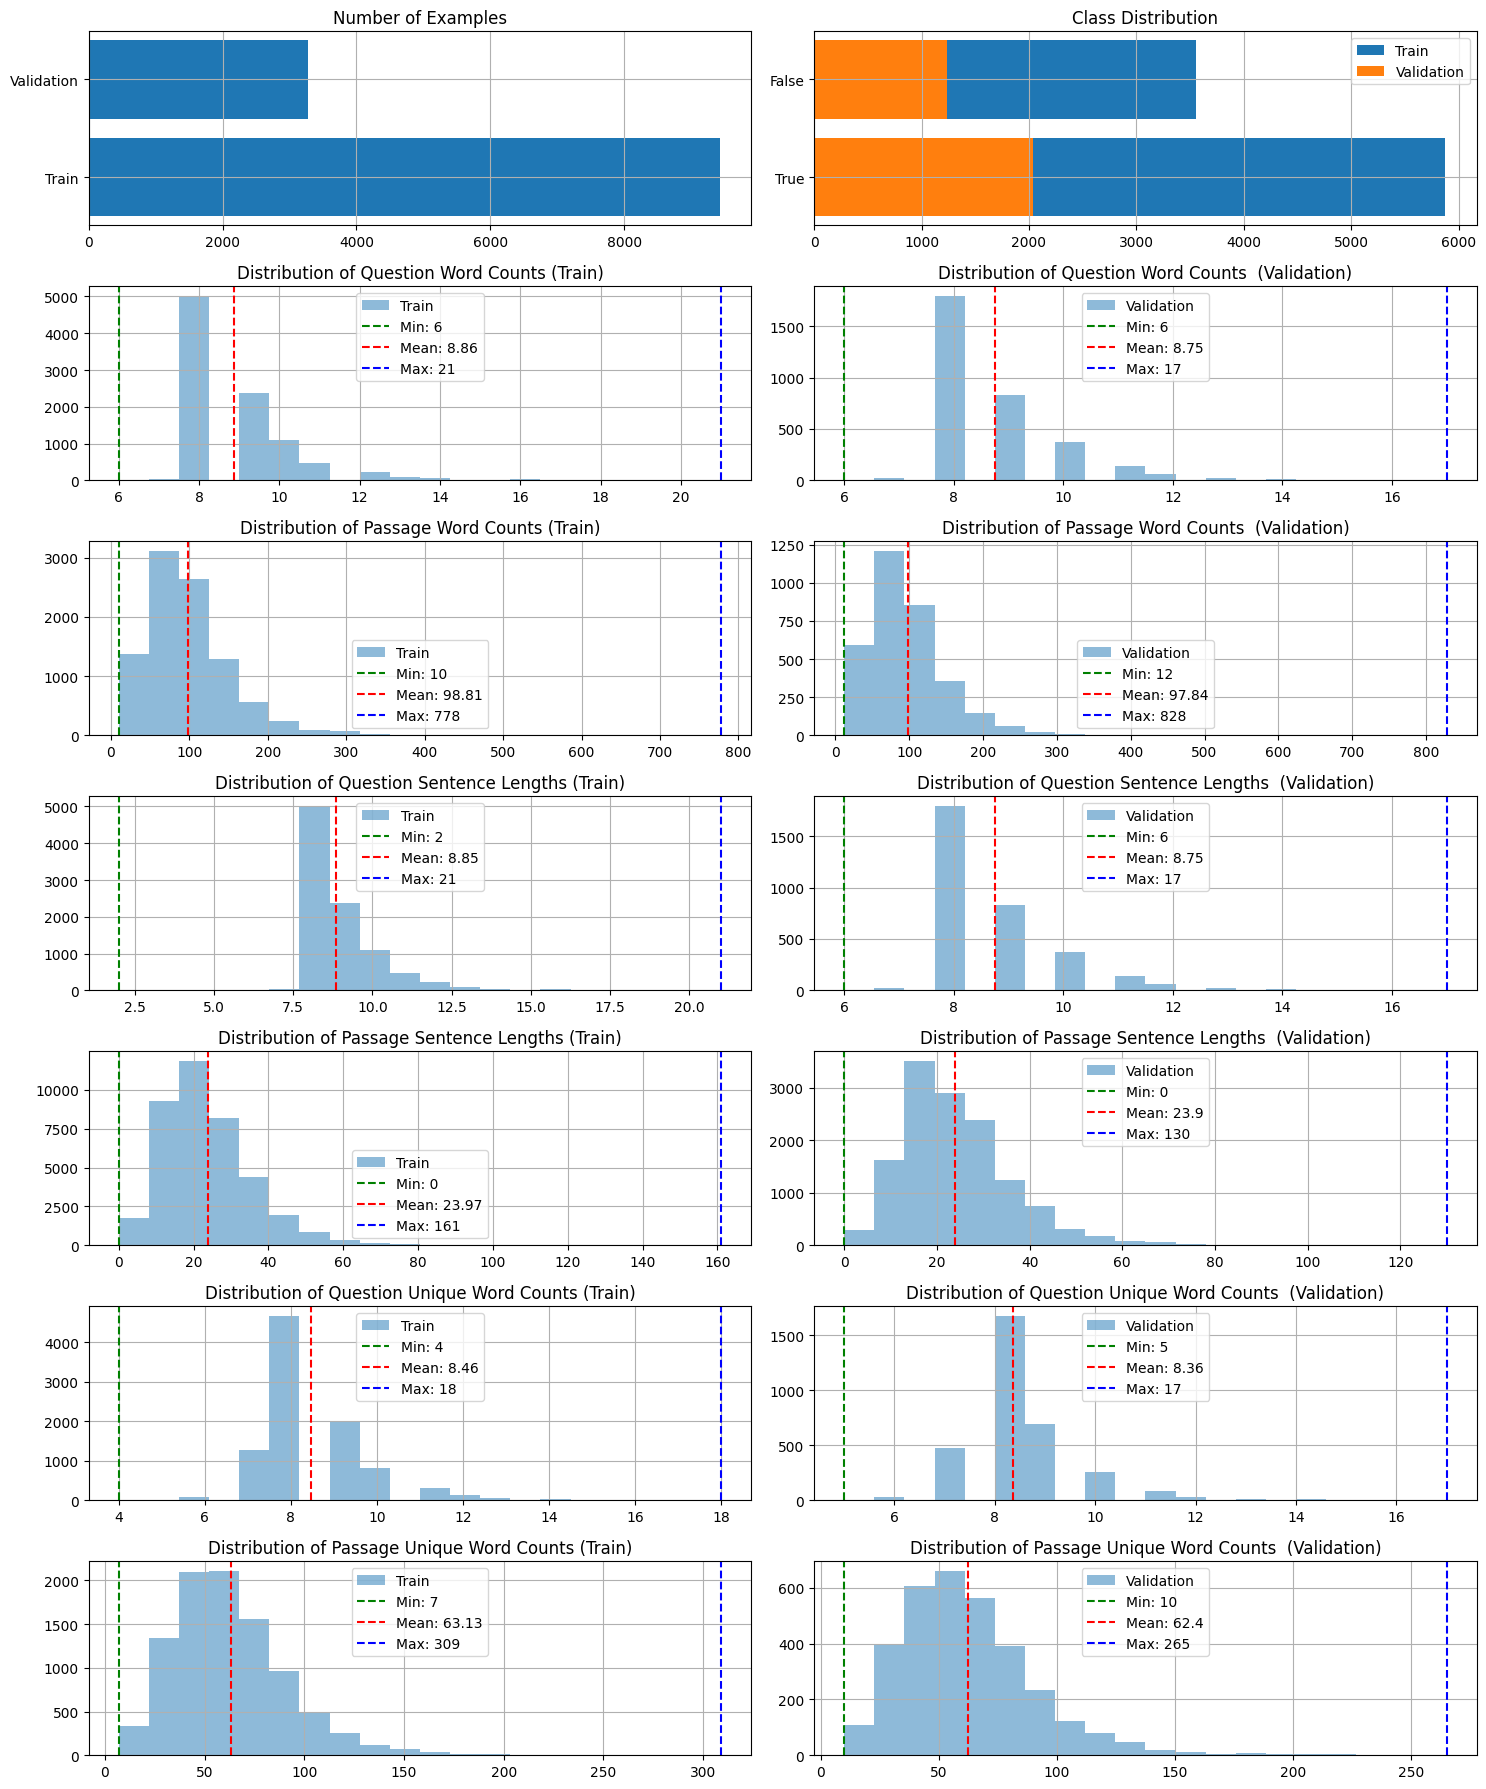

In [8]:
def plot_statistics(train_stats, val_stats):
    fig, axs = plt.subplots(7, 2, figsize=(15, 18))

    axs[0, 0].barh(['Train', 'Validation'], [train_stats['num_examples'], val_stats['num_examples']])
    axs[0, 0].set_title('Number of Examples')
    axs[0, 0].grid(True)
    axs[0, 1].barh([str(key) for key in train_stats['class_distr'].keys()], list(train_stats['class_distr'].values()), label='Train')
    axs[0, 1].barh([str(key) for key in val_stats['class_distr'].keys()], list(val_stats['class_distr'].values()), label='Validation')
    axs[0, 1].set_title('Class Distribution')
    axs[0, 1].legend()
    axs[0, 1].grid(True)

    for i, key in enumerate(list(train_stats.keys())[2:]):
        axs[i+1, 0].hist(train_stats[key][0], bins=20, alpha=0.5, label='Train')
        axs[i+1, 0].axvline(x=train_stats[key][1], color='g', linestyle='--', label=f"Min: {train_stats[key][1]}")
        axs[i+1, 0].axvline(x=train_stats[key][2], color='r', linestyle='--', label=f"Mean: {train_stats[key][2]}")
        axs[i+1, 0].axvline(x=train_stats[key][3], color='b', linestyle='--', label=f"Max: {train_stats[key][3]}")
        axs[i+1, 0].set_title(f'{train_stats[key][4]} (Train)')
        axs[i+1, 0].legend()
        axs[i+1, 0].grid(True)
        axs[i+1, 1].hist(val_stats[key][0], bins=20, alpha=0.5, label='Validation')
        axs[i+1, 1].axvline(x=val_stats[key][1], color='g', linestyle='--', label=f"Min: {val_stats[key][1]}")
        axs[i+1, 1].axvline(x=val_stats[key][2], color='r', linestyle='--', label=f"Mean: {val_stats[key][2]}")
        axs[i+1, 1].axvline(x=val_stats[key][3], color='b', linestyle='--', label=f"Max: {val_stats[key][3]}")
        axs[i+1, 1].set_title(f'{train_stats[key][4]}  (Validation)')
        axs[i+1, 1].legend()
        axs[i+1, 1].grid(True)

    plt.tight_layout()
    plt.show()


train_stats = calculate_statistics_df(train_df)
val_stats = calculate_statistics_df(val_df)

plot_statistics(train_stats, val_stats)

---

# 2. Pretrained embeddings as features for classifier

* ## 2.1 Data vectorization using pre-trained word2vec embeddings.


In [9]:
# Getting pretrained word2vec embeddings

url = "https://drive.google.com/uc?id=1pPPHMNjJAb82-xYFFJLz_kqcnNhmwAhW"
destination = "GoogleNews-vectors-negative300.bin.gz"
gdown.download(url, destination)
!gzip -d GoogleNews-vectors-negative300.bin.gz

Downloading...
From (original): https://drive.google.com/uc?id=1pPPHMNjJAb82-xYFFJLz_kqcnNhmwAhW
From (redirected): https://drive.google.com/uc?id=1pPPHMNjJAb82-xYFFJLz_kqcnNhmwAhW&confirm=t&uuid=dc195ec8-6d5b-49c8-b4da-d124c4f6d86e
To: /content/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:24<00:00, 68.6MB/s]


In [10]:
# Initialization

model_path = 'GoogleNews-vectors-negative300.bin'
word2vec_model = models.KeyedVectors.load_word2vec_format(model_path, binary=True)

In [11]:
def word2vec_vectorizer(tokenized_text):
    return np.mean([word2vec_model[word] for word in tokenized_text if word in word2vec_model], axis=0)

In [12]:
# Encoding

train_encodings = np.vstack(train_df.example_tokenized.apply(word2vec_vectorizer).values)
train_labels = train_df.label.values.astype(int)

val_encodings = np.vstack(val_df.example_tokenized.apply(word2vec_vectorizer).values)
val_labels = val_df.label.values.astype(int)


* ## 2.2  Using pretrained embeddings as features for a classifier. Training RandomForestClassifier. Result description and analysis.


In [13]:
# Model initialization

random_forest = RandomForestClassifier(n_estimators=300, random_state=seed_val, verbose=1, n_jobs=-1)

In [14]:
# Model training

random_forest.fit(train_encodings, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   26.9s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   40.4s finished


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=225, verbose=1)

In [15]:
# Getting predictions

pred_labels = random_forest.predict(val_encodings)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.2s finished


In [16]:
# Accuracy calculation

accuracy_word2vec = accuracy_score(val_labels, pred_labels)
print('Accuracy', round(accuracy_word2vec, 3))

Accuracy 0.673


{False: 1237, True: 2033} 



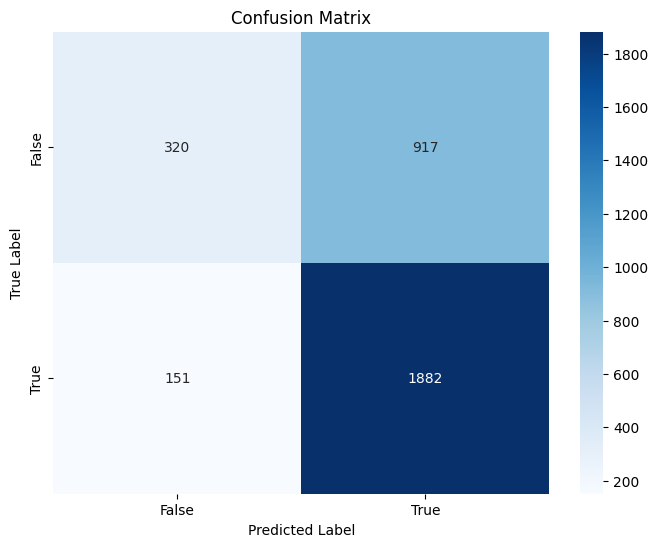

In [17]:
# Confusion matrix

print(val_df.label.value_counts().sort_values().to_dict(), '\n')

conf_matrix = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
(plt.xlabel('Predicted Label'), plt.ylabel('True Label'), plt.title('Confusion Matrix'))
plt.show()

Accuracy of 0.673 indicates that approximately 67.3% of the samples were classified correctly by the RandomForestClassifier. For a balanced dataset this could suggest that the model is performing better than random guessing.


However we are dealing with a slightly imbalanced dataset with True / False balance at 62% / 38%. This means that even a model classifying all examples as positive ones would get 0.62 level of accuracy.


From the confusion matrix above we can see that the number of true and false negatives is small, while the number of false positives is large. This means our model indeed prefers giving positive classification in major cases.


Even though the accuracy result is better than 62%, it looks like the model has just overfit and learnt only how to perform slightly better than simply outputting 'True' for each input.


* ## 2.3 Data vectorization using BERT embeddings.


In [8]:
# Initialization

model_name = 'bert-base-multilingual-cased'
tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

#---------------------#
max_length = 256
#---------------------#

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

In [9]:
# Preparing data

train_questions, train_passages, train_labels = train_df.question.values, train_df.passage.values, train_df.label.values.astype(int)
val_questions, val_passages, val_labels = val_df.question.values, val_df.passage.values, val_df.label.values.astype(int)

In [10]:
# Tokenization and encoding

train_encodings = tokenizer(train_questions.tolist(), train_passages.tolist(), truncation='only_second', padding=True, max_length=max_length,
                            add_special_tokens=False, return_tensors='np', return_attention_mask=False, return_token_type_ids=False)['input_ids']
val_encodings = tokenizer(val_questions.tolist(), val_passages.tolist(), truncation='only_second', padding=True, max_length=max_length,
                          add_special_tokens=False, return_tensors='np', return_attention_mask=False, return_token_type_ids=False)['input_ids']

* ## 2.4  Training RandomForestClassifier using BERT embeddings as features for the classifier. Result description and analysis

In [11]:
# Model initialization

random_forest = RandomForestClassifier(n_estimators=300, random_state=seed_val, verbose=1, n_jobs=-1)

In [12]:
# Model training

random_forest.fit(train_encodings, train_labels)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:    3.2s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   27.8s finished


RandomForestClassifier(n_estimators=300, n_jobs=-1, random_state=225, verbose=1)

In [13]:
# Getting predictions

pred_labels = random_forest.predict(val_encodings)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 300 out of 300 | elapsed:    0.2s finished


In [14]:
# Accuracy calculation

accuracy_bert_encoding = accuracy_score(val_labels, pred_labels)
print('Accuracy', round(accuracy_bert_encoding, 3))

Accuracy 0.65


{False: 1237, True: 2033} 



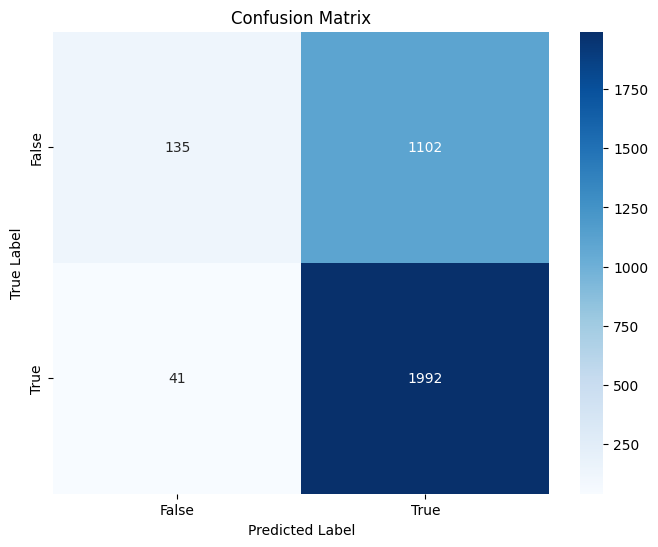

In [15]:
# Confusion matrix

print(val_df.label.value_counts().sort_values().to_dict(), '\n')

conf_matrix = confusion_matrix(val_labels, pred_labels)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
(plt.xlabel('Predicted Label'), plt.ylabel('True Label'), plt.title('Confusion Matrix'))
plt.show()


Again, we have got accuracy at 0.65 for a slightly imbalanced dataset with True / False balance at 62% / 38%, where any  model classifying all examples as positive would get 0.62 level of accuracy.


From the confusion matrix above we can see that the number of true and false negatives is almost 3 times smaller in total compared to word2vec, while the number of false positives is larger by more than 20%. This means our model defenitely prefers giving positive classification in major cases, almost 95% of predictions fall into 'True' class.


Even though the accuracy result is still better than 62%, the model has worsened its perforamnce even being trained on better encodings which encode word context information.


Here we did not include special tokens [CLS] and [SEP] while encoding, because previous experiment with these tokens has shown a slightly lower accuracy of 0.649.

---

# 3. BERT fine-tuning


* ## 3.1 Splitting the data into train and dev. Tokenizing and formating the data, adding special tokens.


In [16]:
# Random seed setting

#---------------------#
random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)
#---------------------#


In [17]:
# Initialization
models = [
    'bert-base-uncased',
    'bert-base-multilingual-cased',
    'roberta-base',
    'roberta-large'
]

model_name = models[3]
tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=True)
# tokenizer = BertTokenizer.from_pretrained(model_name, do_lower_case=True)

#---------------------#
max_length = 256
#---------------------#

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/482 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

In [18]:
# Preparing data

train_questions, train_passages, train_labels = train_df.question.values, train_df.passage.values, train_df.label.values.astype(int)
val_questions, val_passages, val_labels = val_df.question.values, val_df.passage.values, val_df.label.values.astype(int)

In further encoding special tokens are added by default.

In [19]:
# Tokenization and encoding

raw_encodings = tokenizer(train_questions.tolist(), train_passages.tolist(), truncation='only_second', padding=True, max_length=max_length, return_tensors='pt')
val_encodings = tokenizer(val_questions.tolist(), val_passages.tolist(), truncation='only_second', padding=True, max_length=max_length, return_tensors='pt')

In [20]:
# Datasets

raw_dataset = TensorDataset(raw_encodings['input_ids'], raw_encodings['attention_mask'], torch.tensor(train_labels))
val_dataset = TensorDataset(val_encodings['input_ids'], val_encodings['attention_mask'],torch.tensor(val_labels))

In [21]:
# Splitting the data from `train.jsonl`

train_size = int(0.9 * len(raw_dataset))
dev_size = len(raw_dataset) - train_size

train_dataset, dev_dataset = random_split(raw_dataset, [train_size, dev_size])


* ## 3.2   Initializing the model, optimizer and learning rate scheduler. Explaining choice of the parameters.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [23]:
# Model initialization

model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)
# model = BertForSequenceClassification.from_pretrained(model_name, num_labels=2)
model.to(device)

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 1024, padding_idx=1)
      (position_embeddings): Embedding(514, 1024, padding_idx=1)
      (token_type_embeddings): Embedding(1, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-23): 24 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
 

We regard to batch size, learning rate and number of training epochs, at the beginning we use parameters from those proposed by the authors of paper <a href='https://arxiv.org/pdf/1810.04805.pdf'>BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding</a> (Appendix A.3 of the paper). We may change the parameters should further fine-tuning require so.

In [24]:
# Perameters

#---------------------#
batch_size = 16
learning_rate = 2e-5
epsilon = 1e-8
epochs = 4
print_interval = 40
#---------------------#


In [25]:
# Preparation of data loaders

train_dataloader = DataLoader(train_dataset, sampler = RandomSampler(train_dataset), batch_size = batch_size)
dev_dataloader = DataLoader(dev_dataset, sampler = RandomSampler(dev_dataset), batch_size = batch_size)
val_dataloader = DataLoader(val_dataset, sampler = RandomSampler(val_dataset), batch_size = batch_size)

In [26]:
# Initialization of optimizer and learning scheduler

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, eps=epsilon)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 3,
                                            num_training_steps = total_steps)


* ## 3.3 Training loop and BERT fine-tuning. Evaluation on dev set.

The fine-tuning mostly based on two sources:
* Model selection and initialization using AutoTokenizer and AutoModelForSequenceClassification which allows to train RoBERTa models as well: https://medium.com/illuin/deep-learning-has-almost-all-the-answers-yes-no-question-answering-with-transformers-223bebb70189
* Parameter selection, setting of scheduler, gradient cliiping and other tuning options: ghttps://mccormickml.com/2019/07/22/BERT-fine-tuning/

In [27]:
# Training

train_loss, dev_accuracy, accuracy_bert_ft = [[]] * epochs, [], 0

for epoch in tqdm(range(epochs)):
    model.train()
    for step, batch in enumerate(tqdm(train_dataloader)):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        # optimizer.zero_grad()
        model.zero_grad()
        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        train_loss[epoch].append(loss.item())

        if step % print_interval == 0:
            print(f"Epoch {epoch + 1}/{epochs}, Step {step + 1}/{len(train_dataloader)}, Loss: {loss.item():.4f}")

    train_loss[epoch] = np.array(train_loss[epoch]).mean()

# Validation

    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for batch in tqdm(dev_dataloader):
            input_ids, attention_mask, labels = batch
            input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

            outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds)

    accuracy = accuracy_score(all_labels, all_preds)
    dev_accuracy.append(accuracy)

    print(f"Epoch {epoch + 1}/{epochs} - Validation Accuracy: {accuracy:.4f}")

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/531 [00:00<?, ?it/s]

Epoch 1/4, Step 1/531, Loss: 0.6691
Epoch 1/4, Step 41/531, Loss: 0.7059
Epoch 1/4, Step 81/531, Loss: 0.6562
Epoch 1/4, Step 121/531, Loss: 0.6821
Epoch 1/4, Step 161/531, Loss: 0.5767
Epoch 1/4, Step 201/531, Loss: 0.6269
Epoch 1/4, Step 241/531, Loss: 0.7043
Epoch 1/4, Step 281/531, Loss: 0.6778
Epoch 1/4, Step 321/531, Loss: 0.6691
Epoch 1/4, Step 361/531, Loss: 0.6514
Epoch 1/4, Step 401/531, Loss: 0.8553
Epoch 1/4, Step 441/531, Loss: 0.6568
Epoch 1/4, Step 481/531, Loss: 0.6370
Epoch 1/4, Step 521/531, Loss: 0.4736


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 1/4 - Validation Accuracy: 0.6872


  0%|          | 0/531 [00:00<?, ?it/s]

Epoch 2/4, Step 1/531, Loss: 0.5846
Epoch 2/4, Step 41/531, Loss: 0.5414
Epoch 2/4, Step 81/531, Loss: 0.3643
Epoch 2/4, Step 121/531, Loss: 0.5672
Epoch 2/4, Step 161/531, Loss: 1.0418
Epoch 2/4, Step 201/531, Loss: 0.3756
Epoch 2/4, Step 241/531, Loss: 0.6783
Epoch 2/4, Step 281/531, Loss: 0.6082
Epoch 2/4, Step 321/531, Loss: 0.3555
Epoch 2/4, Step 361/531, Loss: 0.3145
Epoch 2/4, Step 401/531, Loss: 0.3970
Epoch 2/4, Step 441/531, Loss: 0.3749
Epoch 2/4, Step 481/531, Loss: 0.5772
Epoch 2/4, Step 521/531, Loss: 0.1651


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 2/4 - Validation Accuracy: 0.8229


  0%|          | 0/531 [00:00<?, ?it/s]

Epoch 3/4, Step 1/531, Loss: 0.2587
Epoch 3/4, Step 41/531, Loss: 0.3944
Epoch 3/4, Step 81/531, Loss: 0.3136
Epoch 3/4, Step 121/531, Loss: 0.1896
Epoch 3/4, Step 161/531, Loss: 0.3998
Epoch 3/4, Step 201/531, Loss: 0.2512
Epoch 3/4, Step 241/531, Loss: 0.3295
Epoch 3/4, Step 281/531, Loss: 0.3031
Epoch 3/4, Step 321/531, Loss: 0.0799
Epoch 3/4, Step 361/531, Loss: 0.3349
Epoch 3/4, Step 401/531, Loss: 0.5956
Epoch 3/4, Step 441/531, Loss: 0.6375
Epoch 3/4, Step 481/531, Loss: 0.4666
Epoch 3/4, Step 521/531, Loss: 0.5214


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 3/4 - Validation Accuracy: 0.8271


  0%|          | 0/531 [00:00<?, ?it/s]

Epoch 4/4, Step 1/531, Loss: 0.1627
Epoch 4/4, Step 41/531, Loss: 0.0275
Epoch 4/4, Step 81/531, Loss: 0.0235
Epoch 4/4, Step 121/531, Loss: 0.0175
Epoch 4/4, Step 161/531, Loss: 0.2783
Epoch 4/4, Step 201/531, Loss: 0.3016
Epoch 4/4, Step 241/531, Loss: 0.1266
Epoch 4/4, Step 281/531, Loss: 0.0096
Epoch 4/4, Step 321/531, Loss: 0.2651
Epoch 4/4, Step 361/531, Loss: 0.2663
Epoch 4/4, Step 401/531, Loss: 0.0072
Epoch 4/4, Step 441/531, Loss: 0.2257
Epoch 4/4, Step 481/531, Loss: 0.0097
Epoch 4/4, Step 521/531, Loss: 0.0073


  0%|          | 0/59 [00:00<?, ?it/s]

Epoch 4/4 - Validation Accuracy: 0.8303


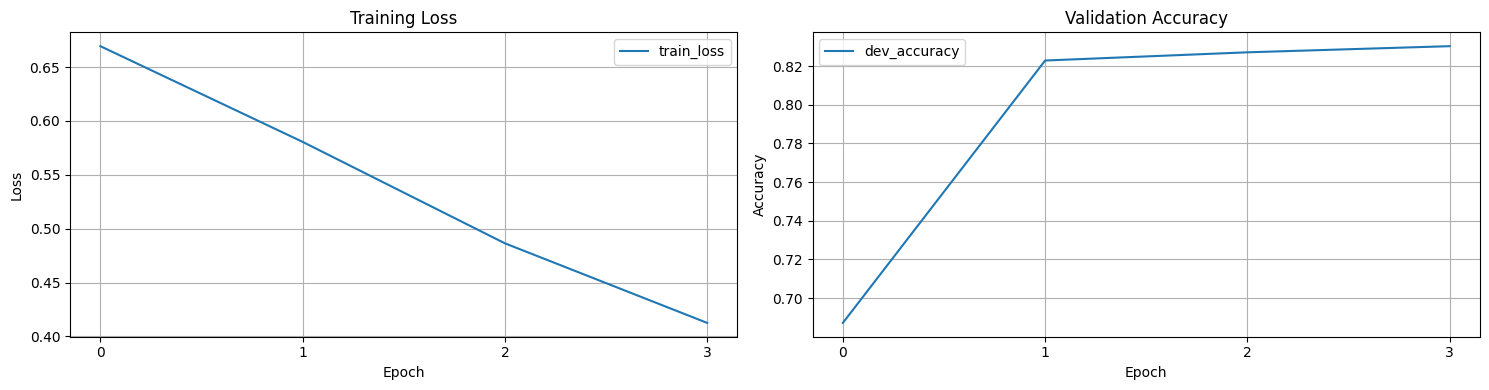

In [28]:
fig, axs = plt.subplots(1, 2, figsize=(15, 4))

axs[0].plot(train_loss, label='train_loss')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_xticks(np.arange(epochs))
axs[0].set_title('Training Loss')
axs[0].legend()
axs[0].grid(True)

axs[1].plot(dev_accuracy, label='dev_accuracy')
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_xticks(np.arange(epochs))
axs[1].set_title('Validation Accuracy')
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()


* ## 3.4 Predictions for the test data. Analysis of the results.

In [30]:
# Testing / Evaluation

model.eval()

all_labels = []
all_preds = []

with torch.no_grad():
    for batch in tqdm(val_dataloader):
        input_ids, attention_mask, labels = batch
        input_ids, attention_mask, labels = input_ids.to(device), attention_mask.to(device), labels.to(device)

        outputs = model(input_ids, token_type_ids=None, attention_mask=attention_mask)
        logits = outputs.logits

        preds = torch.argmax(logits, dim=1).cpu().numpy()
        all_labels.extend(labels.cpu().numpy())
        all_preds.extend(preds)

accuracy_bert_ft = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy_bert_ft:.4f}')

  0%|          | 0/205 [00:00<?, ?it/s]

Test Accuracy: 0.8502


{False: 1237, True: 2033} 



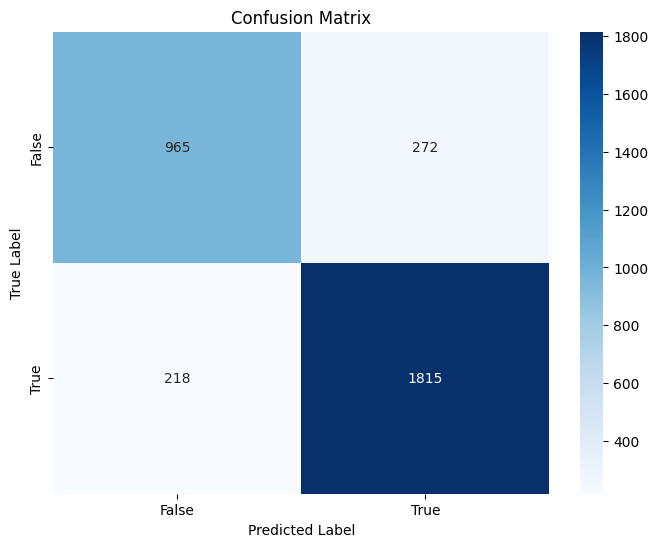

In [31]:
# Confusion matrix

print(val_df.label.value_counts().sort_values().to_dict(), '\n')

conf_matrix = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['False', 'True'], yticklabels=['False', 'True'])
(plt.xlabel('Predicted Label'), plt.ylabel('True Label'), plt.title('Confusion Matrix'))
plt.show()


In this experiment we do not see that model simplifies its output to the positive class. The balance of true and false positives to true and false negatives more-or-less reflects the class balance in the validation dataset. We can conclude that the model manages to capture complex language patterns.

---

# 4. Summary & result analysis

* ## 4.1 Comparison and Interpretation of the results of all the tested models.



In [33]:
all_results = pd.DataFrame({
    'encoding': ['word2vec', 'BERT', 'BERT'],
    'model': ['RandomForestClassifier', 'RandomForestClassifier', 'BertForSequenceClassification'],
    'accuracy': [accuracy_word2vec, accuracy_bert_encoding, accuracy_bert_ft]
}, index = [1, 2, 3])

all_results

,encoding,model,accuracy
1,word2vec,RandomForestClassifier,0.673394
2,BERT,RandomForestClassifier,0.650459
3,BERT,BertForSequenceClassification,0.850153


1. `Experiment 1` has shown low and unreliable model performance. Possible reasons are:
- word2vec vectorization does encode the context of the words, so this information is never taken into account while model training;
- RandomForestClassifier is a relatively simple model for such complex patterns as language inter-word references and cannot effectively capture them.

2. `Experiment 2` has shown even worse model performance. Use of context capturing word encodings did not manage to improve it, and the model simply predicted 'True' in almost 95% cases.
Possible reason is that RandomForestClassifier really cannot effectively capture complex patterns and tends to overfitting instead of that. We need a more complex model.

3. `Experiment 3` was carried out with 4 BERT-like models. All of them have given much higher accuracy score, which is an expected result for this model family. However, the best performer proved to be `roberta-large`. This model captures complex patterns and does not overfit to one specific class. Further improvements can get the model performance even better and decrease the number of false positives andf false negatives.

* ## 4.2 Improvement ideas

* Hyperparameter Tuning: It is reasonable to run a more exhaustive hyperparameter search for the model. The authors of paper <a href='https://arxiv.org/pdf/1810.04805.pdf'>BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding</a> have observed that small data sets of fewer than 100k training examples were noticeably sensitive to hyperparameter choice.

* Data Augmentation: Dealing with a relatively small dataset we can noteceably widen it with augmentation and improve model generalization and performance.  Techniques such as synonym replacement and word masking can be used to generate augmented data.

* Regularization Techniques: we van try to incorporate regularization techniques such as weight decay, dropout, or early stopping to prevent overfitting and improve generalization performance.